# Start

argparse 문제X  
tqdm을 epochs에 걸었었다...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import argparse
from tqdm import tqdm

from model_archive.ResNet import ResNet, Config

import argparse

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/home/jh/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
args = argparse.Namespace(
    model='resnet50',
    batch_size=64,
    lr=5e-5,
    epochs=100,
    root_path='/home/jh/Desktop/VSC/CNN_work/archive/CUB_200_2011/',
    scheduler='no',
    pretrained='no',

    cosLRdecay_lin_end=5
)

In [5]:

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def train(model, iterator, optimizer, criterion, device, scheduler=None):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for step, (x, y) in enumerate(iterator):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        if scheduler=='yes':
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [6]:
# Train
if __name__ == "__main__":
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--model", type=str, default='resnet34')     # resnet18, 34, 50, 101, 152.
    # parser.add_argument("--batch_size", type=int, default=64)
    # parser.add_argument("--lr", type=float, default=1e-3)
    # parser.add_argument("--epochs", type=int, default=100)
    # parser.add_argument("--root_path", type=str, default='/home/jh/Desktop/VSC/CNN_work/archive/CUB_200_2011/')
    # parser.add_argument("--scheduler", type=str, default='no')      # yes / no
    # parser.add_argument("--pretrained", type=str, default='no')     # yes / no
    # # parser.add_argument("--half", type=str, default='no')           # yes / no
    # args = parser.parse_args()

    print()
    print('<< Configurations >>')
    print(f'[*] Model       - {args.model}')
    print(f'[*] Batch_size  - {args.batch_size}')
    print(f'[*] LR          - {args.lr}')
    print(f'[*] Epochs      - {args.epochs}')

    # Dataset
    pretrained_size = 224
    pretrained_means = [0.485, 0.456, 0.406]
    pretrained_stds= [0.229, 0.224, 0.225]
    train_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(pretrained_size, padding = 10),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                        ])
    test_transforms = transforms.Compose([
                            transforms.Resize(pretrained_size),
                            transforms.CenterCrop(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = pretrained_means, 
                                                    std = pretrained_stds)
                        ])
    ROOT = args.root_path
    data_dir = os.path.join(ROOT, 'CUB_200_2011')
    images_dir = os.path.join(data_dir, 'images')
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')

    train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)
    test_data = datasets.ImageFolder(root = test_dir,
                                    transform = test_transforms)
    
    VALID_RATIO = 0.8
    n_train_examples = int(len(train_data)*VALID_RATIO)
    n_valid_examples = len(train_data) - n_train_examples

    train_data, valid_data = data.random_split(train_data,
                                            [n_train_examples, n_valid_examples])
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms

    BATCH_SIZE = args.batch_size
    train_iterator = data.DataLoader(train_data, 
                                    shuffle = True, 
                                    batch_size = BATCH_SIZE)
    valid_iterator = data.DataLoader(valid_data, 
                                    batch_size = BATCH_SIZE)
    test_iterator = data.DataLoader(test_data, 
                                    batch_size = BATCH_SIZE)

    # Model Zoo
    if args.model=='resnet18':
        if args.pretrained=='yes':
            downloaded_model = models.resnet18(pretrained = True)
            print('[*] pre-trained model being used!')
        else:
            downloaded_model = models.resnet18(pretrained = False)
            print('[*] train newly initialized model!')
    elif args.model=='resnet34':
        if args.pretrained=='yes':
            downloaded_model = models.resnet34(pretrained = True)
            print('[*] pre-trained model being used!')
        else:
            downloaded_model = models.resnet34(pretrained = False)
            print('[*] train newly initialized model!')
    elif args.model=='resnet50':
        if args.pretrained=='yes':
            downloaded_model = models.resnet50(pretrained = True)
            print('[*] pre-trained model being used!')
        else:
            downloaded_model = models.resnet50(pretrained = False)
            print('[*] train newly initialized model!')
    elif args.model=='resnet101':
        if args.pretrained=='yes':
            downloaded_model = models.resnet101(pretrained = True)
            print('[*] pre-trained model being used!')
        else:
            downloaded_model = models.resnet101(pretrained = False)
            print('[*] train newly initialized model!')
    elif args.model=='resnet152':
        if args.pretrained=='yes':
            downloaded_model = models.resnet152(pretrained = True)
            print('[*] pre-trained model being used!')
        else:
            downloaded_model = models.resnet152(pretrained = False)
            print('[*] train newly initialized model!')
    config = Config()
    resnet_config = config.get_resnet_config(model_name = args.model)


    # Change FC layer in model for transfer learning.
    IN_FEATURES = downloaded_model.fc.in_features 
    OUTPUT_DIM = len(test_data.classes)
    downloaded_model.fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

    START_LR = args.lr
    model = ResNet(resnet_config, OUTPUT_DIM)
    print(f'[*] Parameters  - {count_parameters(model):,}')
    # if args.half=='yes':
    #     model = model.half()

    optimizer = optim.Adam(model.parameters(), lr=START_LR)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()

    if args.scheduler == 'yes':
        # cosine scheduler
        '''
        - 기존 lr overfitting지점인, 30-40 에 다다르기 전에 decay주는게 적합해보여.
        - 한번 그렇게 ``lr==0`` 까지 탐색하는것보단, hard_reset하면서 그 optima에서 빠져나와서 
          주변 다른 optima 들어가보는것도 좋지 않을까?
        - 지금 실험상황은 best 모델 찾는거고, epoch 100 가면서 어차피 튀는 경향성 보이니, 좋은 시도같은데?
        '''
        ITERATIONS = args.epochs * len(train_iterator)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=ITERATIONS, eta_min=1e-8)
    else:
        scheduler=None

    model = model.to(device)
    criterion = criterion.to(device)

    # writer = SummaryWriter()


<< Configurations >>
[*] Model       - resnet50
[*] Batch_size  - 64
[*] LR          - 5e-05
[*] Epochs      - 100
[*] train newly initialized model!
[*] Parameters  - 23,917,832


## Modifing Train

linear warmup있는 cosine LR decay

In [7]:
def cosineDecayWithLinearWarmup_demo(MAX_EPOCH, lin_end, epoch, train_loader, step):
    import math
    '''
    input   :   max_epoch  : max_epoch of whole training stage.
                lin_end  : end epoch of linear warmup stage.
                epoch(current step's / must starts from 0)  
                train_loader (for len(train_loader)...)  
                current step_num (might should use enumerate)  
    output  :   lr_계수 that will be multiplied with lr for current step before optimizer.step().  
    '''
    
    lin_end_steps = lin_end*len(train_loader) # lin_warmup이 끝나는 지점
    iter_per_epoch = len(train_loader)
    whole_steps = iter_per_epoch*MAX_EPOCH - lin_end_steps  # 'whole_steps' is whole iteration steps.
    whole_steps_cos = whole_steps - lin_end_steps   # pure cosine #steps.

    if epoch < lin_end:
        lr_const = (step + epoch*iter_per_epoch)/lin_end_steps  # 선형 증가 비율계산
        return lr_const
    else:
        T = (MAX_EPOCH-lin_end)*iter_per_epoch
        t = (epoch - lin_end)*iter_per_epoch + step
        lr_const = 0.5*(1+math.cos(t/T*math.pi))
        return lr_const


만든 함수에 맞게, 바꿔줌.

In [8]:
def train_cosLRdecay(model, iterator, optimizer, criterion, device, MAX_EPOCH, lin_end, epoch, lr, scheduler='no'):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for step, (x, y) in enumerate(iterator):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        ##################################
        # MAX_EPOCH, lin_end, epoch, train_loader, step
        for g in optimizer.param_groups:
            lr_const = cosineDecayWithLinearWarmup_demo(MAX_EPOCH, lin_end, epoch, iterator, step)
            print(lr, lr_const)
            g['lr'] = lr * lr_const
        ##################################

        optimizer.step()
        
        if scheduler=='yes':
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5, lr_const

BELOW : 학습 돌리기 코드

In [9]:
# Model training.
best_valid_loss = float('inf')
best_valid_epoch = 0
_lr_check_list =[]      # !!!

print('[*] Start Training !', end='\n\n')
for epoch in range(args.epochs):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5, lr_const = train_cosLRdecay(model, train_iterator, optimizer, criterion, device, args.epochs, args.cosLRdecay_lin_end, epoch, args.lr, scheduler)
    _lr_check_list.append(lr_const)     # !!!
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    # writer.add_scalar("loss/train", train_loss, epoch)  # tensorboard
    # writer.add_scalar("loss/val", valid_loss, epoch)    # tensorboard

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_epoch = epoch
        torch.save(model.state_dict(), f'./saved/{args.model}_bs{args.batch_size}_lr{args.lr}_epochs{args.epochs}_pretrained-{args.pretrained}.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
        f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
        f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print()
print(f"Best valid epoch : {best_valid_epoch}/{args.epochs} epochs")

# writer.flush()

[*] Start Training !

5e-05 0.0
5e-05 0.001694915254237288
5e-05 0.003389830508474576
5e-05 0.005084745762711864
5e-05 0.006779661016949152
5e-05 0.00847457627118644
5e-05 0.010169491525423728
5e-05 0.011864406779661017
5e-05 0.013559322033898305
5e-05 0.015254237288135594
5e-05 0.01694915254237288
5e-05 0.01864406779661017
5e-05 0.020338983050847456
5e-05 0.022033898305084745
5e-05 0.023728813559322035
5e-05 0.025423728813559324
5e-05 0.02711864406779661
5e-05 0.0288135593220339
5e-05 0.030508474576271188
5e-05 0.03220338983050847
5e-05 0.03389830508474576
5e-05 0.03559322033898305
5e-05 0.03728813559322034
5e-05 0.03898305084745763
5e-05 0.04067796610169491
5e-05 0.0423728813559322
5e-05 0.04406779661016949
5e-05 0.04576271186440678
5e-05 0.04745762711864407
5e-05 0.04915254237288136
5e-05 0.05084745762711865
5e-05 0.05254237288135593
5e-05 0.05423728813559322
5e-05 0.05593220338983051
5e-05 0.0576271186440678
5e-05 0.059322033898305086
5e-05 0.061016949152542375
5e-05 0.062711864406

lr_const 잘 작동하는지 확인요망(아래 실행)  
다른 batch 등등에 대해서도 작동하는지 봐야겠는걸?

In [ ]:
import matplotlib.pyplot as plt

plt.plot(_lr_check_list)

## Cosine LR Decay 만들기

- 깃허브에 올려서 사람들 쓸 수 있게 API 만들어볼 수 없나?  
- 어떻게 contribute 그런거 해보지?  

---
TODO  
- pytorch API -> optimizer 상속받아서 만든다면??  
- optimizer wrapper로 만들어보기

In [234]:
def cosineDecayWithLinearWarmup(MAX_EPOCH, lin_end, epoch, train_loader, step):
    import math
    '''
    input   :   max_epoch  
                lin_end  
                epoch(current step's / must starts from 0)  
                train_loader (for len(train_loader)...)  
                current step_num (might should use enumerate)  
    output  :   lr_계수 that will be multiplied with lr for current step before optimizer.step().  
    '''
    
    # 'lin_end' is a end epoch of linear warmup stage.
    lin_end_steps = lin_end*len(train_loader) # lin_warmup이 끝나는 지점
    iter_per_epoch = len(train_loader)
    whole_steps = iter_per_epoch*MAX_EPOCH - lin_end_steps  # 'whole_steps' is whole iteration steps.
    whole_steps_cos = whole_steps - lin_end_steps   # pure cosine #steps.
    lili.append(whole_steps_cos)
    # returning lr_c is 계수 that will be multiplied for current step lr.
    if epoch < lin_end:
        lr_const = (step + epoch*iter_per_epoch)/lin_end_steps  # 선형 증가 비율계산
        return lr_const
    else:
        T = (MAX_EPOCH-lin_end)*iter_per_epoch
        t = (epoch - lin_end)*iter_per_epoch + step
        lr_const = 0.5*(1+math.cos(t/T*math.pi))
        return lr_const


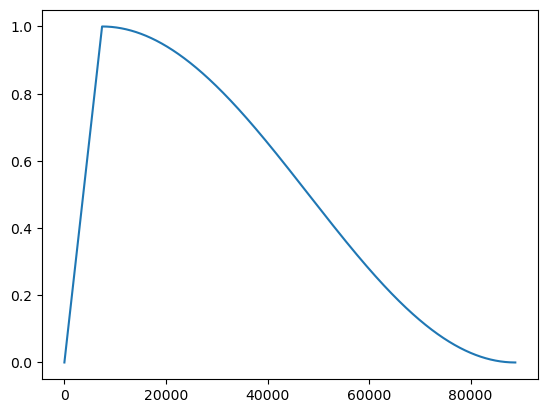

In [232]:
# Simulation
MAX_EPOCH = 120
lin_end = 10
lr=[]

for epoch in range(MAX_EPOCH):
    for i in range(len(train_loader)):  # 실제론 enumerate 해야겠네 for step in iteration
        lr_c= cosineDecayWithLinearWarmup(MAX_EPOCH, lin_end, epoch, train_loader, i)
        lr.append(lr_c)

import matplotlib.pyplot as plt

plt.plot(lr)

### Cosine LR Decay 실 검증

In [ ]:
# 학습 돌리기 코드
best_valid_loss = float('inf')
best_valid_epoch = 0

print('[*] Start Training !', end='\n\n')
for epoch in range(args.epochs):
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device, scheduler)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_epoch = epoch
        torch.save(model.state_dict(), f'./saved/{args.model}_bs{args.batch_size}_lr{args.lr}_epochs{args.epochs}_pretrained-{args.pretrained}.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
        f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
        f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

print()
print(f"Best valid epoch : {best_valid_epoch}/{args.epochs} epochs")

# low-precision

In [36]:
model.half()

for name, param in model.named_parameters():
    print('name')
    print(type(param))
    print(param.shape)
    print(param.dtype)
    print(param.requires_grad)
    print('===')

name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64, 3, 7, 7])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64, 64, 1, 1])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64, 64, 3, 3])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([64])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([256, 64, 1, 1])
torch.float16
True
===
name
<class 'torch.nn.parameter.Parameter'>
torch.Size([256])
torch.float16
True
===
name
<class 'torch.nn.parameter.Par

# _train